In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Balanced

In [2]:
separated_means = [[-3, 2], [-1.5, 2], [0, 2], [1.5, 2], [3, 2], [-3, 0], [-1.5, 0], [0, 0], [1.5, 0], [3, 0]]
overlapped_means = [[-2, 1], [-1.5, 1], [0, 1], [1.5, 1], [2, 1], [-2, 0], [-1.5, 0], [0, 0], [1.5, 0], [2, 0]]
highly_overlapped_means = [[-2, 1], [-1.5, 1], [-1, 1], [-0.5, 1], [0, 1], [-2, 0], [-1.5, 0], [-1, 0], [-0.5, 0], [0, 0]]

In [3]:
size_per_category = 1000

In [4]:
palette = ['red', 'green', 'blue', 'cyan', 'magenta', 'orange', 'yellow', 'lightgreen', 'skyblue', 'orchid']

In [5]:
def generate_distribution(mean_array, size_per_category):
    points = pd.DataFrame()
    x = []
    y = []
    category = []
    index = 0
    for mean in mean_array:
        gaussian_normal_points = np.random.normal(loc=mean, scale=[0.3,0.3], size=[size_per_category, 2])
        x += list(gaussian_normal_points[:, 0])
        y += list(gaussian_normal_points[:, 1])
        category += [index] * size_per_category
        index += 1
    points['x'] = x
    points['y'] = y
    points['category'] = category
    return points

In [6]:
def plot_distribution(distribution):
    legend = [('Category '+ str(index+1)) for index in range(10)]
    plt.figure(figsize=(15,8))
    for index in range(10):
        data = distribution[distribution['category'] == index]
        plt.scatter(data['x'], data['y'], c=palette[index], s=5)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend((legend), loc=1)

In [7]:
separated = generate_distribution(separated_means, size_per_category)
#plot_distribution(separated)

In [8]:
overlapped = generate_distribution(overlapped_means, size_per_category)
#plot_distribution(overlapped)

In [9]:
highly_overlapped = generate_distribution(highly_overlapped_means, size_per_category)
#plot_distribution(highly_overlapped)

# Imbalanced

Run for r in [0.01, 0.05, 0.1, 0.5, 0.9] and m in [1,9]

Simulating for one test case:

In [10]:
m = 2
r = 0.01
k = 10
imbalanced_size = 2000

In [11]:
def sample_imbalanced_data(data, imbalanced_size, m, r, k):
    p_min = r/10 #for m classes
    p_max = (1 - (p_min * m))/(k - m) #for k-m classes
    minority_positions = ([p_min] * m + [p_max] * (k - m))
    np.random.shuffle(minority_positions)
    class_probabilities = [(proba/size_per_category) for proba in minority_positions]
    p = [class_probabilities[category] for category in data['category']]
    indices = np.arange(len(data))
    selected_indices = np.random.choice(indices, imbalanced_size, p=p)
    imbalanced_samples = data.iloc[selected_indices, :]
    imbalanced_samples.reset_index(inplace=True, drop=True)
    return imbalanced_samples

In [12]:
separated_imbalanced = sample_imbalanced_data(separated, imbalanced_size, m, r, k)
#plot_distribution(separated_imbalanced)

In [13]:
overlapped_imbalanced = sample_imbalanced_data(overlapped, imbalanced_size, m, r, k)
#plot_distribution(overlapped_imbalanced)

In [14]:
highly_overlapped_imbalanced = sample_imbalanced_data(highly_overlapped, imbalanced_size, m, r, k)
#plot_distribution(highly_overlapped_imbalanced)

In [15]:
def imbalance_ratio(data):
    value_counts = data['category'].value_counts()
    counts = [count for category, count in value_counts.iteritems()]
    count_max = max(counts)
    count_min = min(counts)
    IR = count_max / count_min
    return IR

In [17]:
def hellinger_distance(vec1, vec2):
    return np.sqrt(np.sum((np.sqrt(vec1) - np.sqrt(vec2)) ** 2)) / np.sqrt(2)

In [18]:
def imbalance_degree(data, c):
    value_counts = data['category'].value_counts()
    counts = [count for category, count in value_counts.iteritems()]
    size = len(data)
    p = np.array(counts) / size
    if (len(p) < c):
        p = np.concatenate((p, [0] * (c-len(p))))
    b = [1/c] * c
    m = 0
    for prob in (p-b):
        if prob < 0:
            m +=1
    p_m = [0] * m + [1/c] * (c-m-1) + [1-(c-m-1)/c]
    ID = (hellinger_distance(p,b) / hellinger_distance(p_m,b)) + (m-1)
    return ID

In [20]:
def log_likelihood_index(data):
    c = len(np.unique(data['category']))
    b = np.array([1/c] * c)
    value_counts = data['category'].value_counts()
    size = len(data)
    proba = [(count/size) for category, count in value_counts.iteritems()]
    n = [count for _, count in value_counts.iteritems()]
    summation = np.sum([(p*np.log(p*c)) for p in proba])
    LLI = 2 * summation
    return LLI

In [107]:
def tangential_imbalance_degree(data):
    c = len(np.unique(data['category']))
    b = np.array([1/c] * c)
    value_counts = data['category'].value_counts()
    size = len(data)
    proba = [(count/size) for category, count in value_counts.iteritems()]
    n = [count for _, count in value_counts.iteritems()]
    TID = np.sum(proba * np.tan(proba-b))
    return TID

# Simulating for all values

In [108]:
def compute_graphs(distribution, imbalanced_size, k):
    results = []
    for m in range(1,k):
        IR = []
        ID = []
        LLI = []
        TID = []
        for r in [0.01, 0.05, 0.1, 0.5, 0.9]:
            imbalanced_data = sample_imbalanced_data(distribution, imbalanced_size, m, r, k)
            IR.append(imbalance_ratio(imbalanced_data))
            ID.append(imbalance_degree(imbalanced_data, k))
            LLI.append(log_likelihood_index(imbalanced_data))
            TID.append(tangential_imbalance_degree(imbalanced_data))
        result = {}
        result['ir'] = IR
        result['id'] = ID
        result['lli'] = LLI
        result['tid'] = TID
        results.append(result)
    return results

In [112]:
def plot_graph(distribution, metric, legend, k=10, imbalanced_size=5000):
    data_points = compute_graphs(distribution, imbalanced_size, k)
    #plt.figure(figsize=(10,6))
    index = 0
    r_values = [0.01, 0.05, 0.1, 0.5, 0.9999]
    legend = [('m = ' + str(i)) for i in range(1,10)]
    for category in data_points:
        scores = category[metric]
        plt.plot(r_values, scores)
        plt.xlabel('r')
        plt.ylabel(metric.upper())
        print(scores)
    plt.legend((legend), loc=1, fontsize='medium', framealpha=0.2)

[0.19742866850764437, 0.17831122989733827, 0.13492022521160327, 0.0328512596827005, 0.0028740872250940797]
[0.4252156378239013, 0.34779228552062597, 0.31370066350298575, 0.07281578126462444, 0.0063626806612221976]
[0.6917624466445629, 0.5977687284913047, 0.5111523624666597, 0.12405868490059624, 0.005310013366664083]
[0.9747277944977121, 0.8513283707048452, 0.7105168103180154, 0.17640542199037046, 0.006804877865154654]
[1.305224287557901, 1.1497297827950381, 0.9662203739448867, 0.24451436168497911, 0.00874423360502934]
[1.760592431120654, 1.5560518936006444, 1.3393352442480386, 0.3774699326277179, 0.016674499682730878]
[2.294006763758951, 2.015545978067002, 1.7956481192234162, 0.5324495641822437, 0.01814692325688149]
[3.1179583317647492, 2.777696962723722, 2.423160823009392, 0.7717486424418875, 0.039748877995427284]
[4.467189265054617, 4.088494037996387, 3.5361480367166704, 1.2490525954227825, 0.06431449866701329]


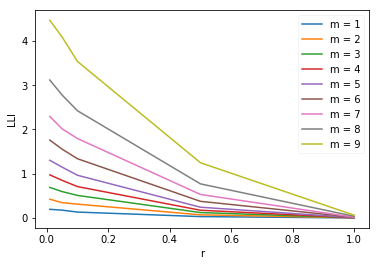

In [113]:
plot_graph(highly_overlapped, 'lli', legend=True)

[0.01140463444355449, 0.010074780129421274, 0.009466732028985979, 0.0027697338232320905, 0.00034900125456009505]
[0.02449226909354552, 0.022990647116609315, 0.021342189575591673, 0.005793788352987729, 0.00044835496436048555]
[0.042130828630581284, 0.03906683063050177, 0.03624158884616861, 0.010471439741705345, 0.00087873585998508]
[0.0651599450935627, 0.06094251269678401, 0.05349787707044154, 0.018719560855940152, 0.0009132838672358144]
[0.09827998925393175, 0.0912104560422079, 0.08069809768905722, 0.02592625377003741, 0.0007743738959918767]
[0.14824714992440874, 0.13621193337165477, 0.12368614777593068, 0.035415631284881476, 0.001316689652223346]
[0.23303934425352119, 0.21474412362031928, 0.1921879719528734, 0.06003906155777834, 0.0024577652729644442]
[0.41590823420720746, 0.3823608883005884, 0.3377803701046235, 0.10458773347503361, 0.004982548201884774]
[1.2197327133413827, 1.0842125401014429, 0.9363019409138069, 0.23426553035246975, 0.00871208676373696]


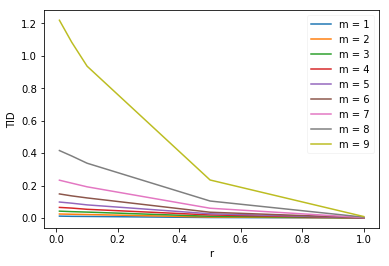

In [114]:
plot_graph(highly_overlapped, 'tid', legend=True)